In [2]:
import tensorflow as tf
import tools.mnist as mnist_tools
import tools.semisup as semisup
import numpy as np
import architectures as arch
%load_ext autoreload

/home/frankzl/.envs/env36-ml/.venv/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
train_images, train_labels = mnist_tools.get_data('train')
test_images, test_labels = mnist_tools.get_data('test')

Extracting /home/frankzl/datasets/mnist/train-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/train-labels-idx1-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/frankzl/datasets/mnist/t10k-labels-idx1-ubyte.gz


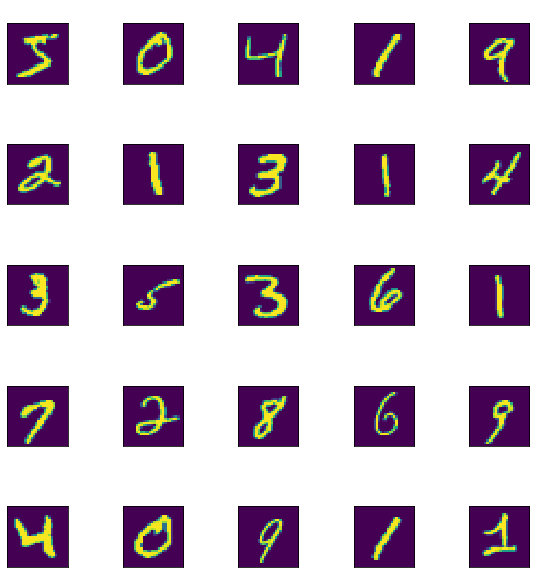

In [78]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

def imshow(images, labels = None, num_row=5):
    
    labels = len(images)*[" "] if labels == None else labels
    
    gs = gridspec.GridSpec(math.ceil(len(images)/num_row),num_row, hspace=1)
    f  = plt.figure(figsize=(10,10))
    
    for idx in range(len(images)):
        ax = plt.subplot(gs[idx])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(labels[idx])
        ax.imshow(images[idx].reshape(-1,28))
    
imshow(train_images[:25])

In [79]:
# labeled samples used per class
sup_per_class = 10
sup_seed = -1
# labeled samples per class per batch
sup_per_batch = 10
unsup_batch_size = 100


NUM_LABELS = mnist_tools.NUM_LABELS
IMAGE_SHAPE = mnist_tools.IMAGE_SHAPE
seed = 1

# gets sup_per_class samples for each class
# [10 (classes), 10 (samples), 28, 28, 1]
sup_by_label = semisup.sample_by_label(train_images, train_labels,
                        sup_per_class, NUM_LABELS, seed)

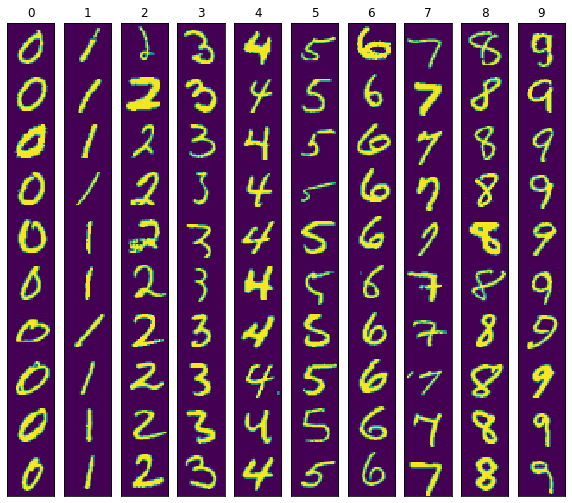

In [80]:
imshow(sup_by_label, labels=list(range(0,10)), num_row=10)

In [84]:
def create_input(input_images, input_labels, batch_size):
    
    if input_labels is not None:
        training_dataset = tf.data.Dataset.from_tensor_slices((input_images, input_labels)).batch(batch_size)
    else:
        training_dataset = tf.data.Dataset.from_tensor_slices(input_images).batch(batch_size)
    iterator = training_dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def create_per_class_input(images_by_class, n_per_class, class_labels=None):
     
    if class_labels is None:
        class_labels = np.arange(len(images_by_class))
    
    batch_images, batch_labels = [], []
    
    for images, label in zip (images_by_class, class_labels):
        labels = tf.fill([len(images)], label)
        images, labels = create_input(images, labels, n_per_class)
        batch_images.append(images)
        batch_labels.append(labels)
    
    return tf.concat(batch_images, 0), tf.concat(batch_labels, 0)
    

graph = tf.Graph()

with graph.as_default():
    
    t_unsup_images, _ = create_input(train_images, train_labels, unsup_batch_size)
    t_sup_images, t_sup_labels = create_per_class_input(sup_by_label, sup_per_batch)
    

with tf.Session(graph=graph) as sess:
    unsup, x,y = sess.run([t_unsup_images, t_sup_images, t_sup_labels])


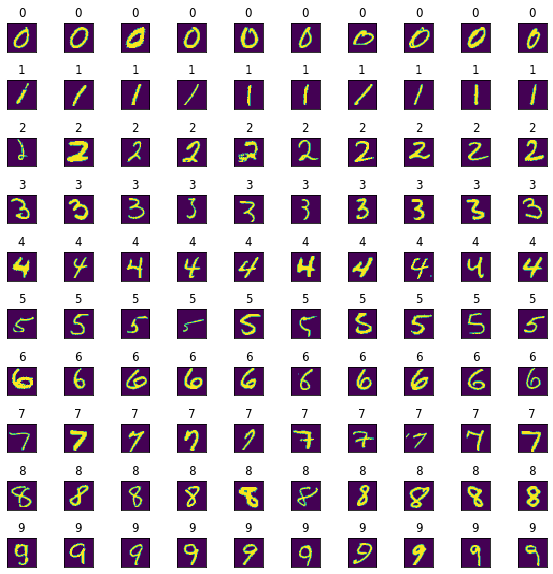

In [85]:
imshow(x, list(y), num_row=10)

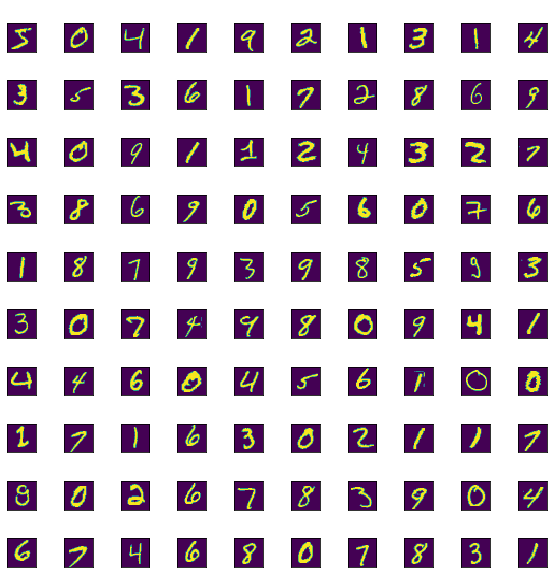

In [86]:
imshow(unsup, num_row=10)